In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

float_type='float32'

gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
from import_mnist import *

val_x=data_x[-10000:]
val_y=data_y[-10000:]
val_l=data_l[-10000:]
data_x=data_x[:-10000]
data_y=data_y[:-10000]
data_l=data_l[:-10000]

print(data_x.shape)
print(data_y.shape)
print(data_l.shape)

print(val_x.shape)
print(val_y.shape)
print(val_l.shape)

print(test_x.shape)
print(test_y.shape)
print(test_l.shape)

mean=tf.math.reduce_mean(np.arcsin(data_x**0.5),axis=0,keepdims=True).numpy()
std=tf.math.reduce_std(np.arcsin(data_x**0.5),axis=0,keepdims=True).numpy()

transf=lambda x: (np.arcsin(x**0.5)-mean)/(std+10**-20)
destransf=lambda x: np.sin(x*(std+10**-20)+mean)**2

data_x=transf(data_x)
val_x=transf(val_x)
test_x=transf(test_x)

(240000, 784)
(240000,)
(240000, 10)
(10000, 784)
(10000,)
(10000, 10)
(10000, 784)
(10000,)
(10000, 10)


In [19]:
wei_reg=tf.keras.regularizers.L2(0*10**-3)
enc_reg=tf.keras.regularizers.L2(0*10**-1)

# zero=10**(-5)
# def enc_reg(x):
#     return -0.01 * tf.math.reduce_sum(0.001*tf.math.log(x+zero)+0.999*tf.math.log(1-x+zero))
    
    
mid_act='elu'
enc_act='linear'
end_act='linear'

loss=tf.keras.losses.MeanSquaredError()
#loss=tf.keras.losses.BinaryCrossentropy()
#loss=tf.keras.losses.BinaryCrossentropy()
metrics=['accuracy']
optimizer = tf.keras.optimizers.Adam(learning_rate=10**-3, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

layers_encode=[
    tf.keras.layers.Reshape(           [28,28,1]                                                        ),
    tf.keras.layers.Conv2D(         32,[3,3], activation=mid_act,             kernel_regularizer=wei_reg),
    tf.keras.layers.AveragePooling2D(  [2,2]                                                            ),
    tf.keras.layers.Conv2D(         16,[4,4], activation=mid_act,             kernel_regularizer=wei_reg),
    tf.keras.layers.AveragePooling2D(  [2,2]                                                            ),
    tf.keras.layers.Flatten(                                                                            ),
    tf.keras.layers.Dense(          256,      activation=mid_act,             kernel_regularizer=wei_reg),
    tf.keras.layers.Dense(          5,        activation=enc_act,             kernel_regularizer=wei_reg,  activity_regularizer=enc_reg)
]
layers_decode=[
    tf.keras.layers.Dense(          256,    activation=mid_act,              kernel_regularizer=wei_reg),
    tf.keras.layers.Dense(          5*5*16,   activation=mid_act,              kernel_regularizer=wei_reg),
    tf.keras.layers.Reshape(           [5,5,16]                                                          ),
    tf.keras.layers.Conv2DTranspose(32,[5,5], strides=(2,2), activation=mid_act,              kernel_regularizer=wei_reg),
    tf.keras.layers.Conv2DTranspose(1,[4,4], strides=(2,2), activation=mid_act,kernel_regularizer=wei_reg),
    tf.keras.layers.Conv2DTranspose(1,[1,1], strides=(1,1), activation=end_act,kernel_regularizer=wei_reg),
    tf.keras.layers.Flatten()
]

# layers_encode=[
#     tf.keras.layers.Dense(512, activation=mid_act,kernel_regularizer=wei_reg),
#     tf.keras.layers.Dense(256, activation=mid_act,kernel_regularizer=wei_reg),
#     tf.keras.layers.Dense(2,activity_regularizer=enc_reg)
# ]
# layers_decode=[
#     #tf.keras.layers.Dense(256, activation=mid_act,kernel_regularizer=wei_reg),
#     #tf.keras.layers.Dense(16, activation=mid_act,kernel_regularizer=wei_reg),
#     tf.keras.layers.Dense(16, activation=mid_act,kernel_regularizer=wei_reg),
#     tf.keras.layers.Dense(10, activation=end_act,kernel_regularizer=wei_reg)
# ]

enc_x=tf.keras.layers.Input([28*28])
dec_x=tf.keras.layers.Input([5])

encode=enc_x
for layer in layers_encode:
    encode=layer(encode)
    
decode_full=encode
decode_part=dec_x
for layer in layers_decode:
    decode_full=layer(decode_full)
    decode_part=layer(decode_part)

Encoder=tf.keras.Model(enc_x, encode)
Decoder=tf.keras.Model(dec_x, decode_part)
Network=tf.keras.Model(enc_x, decode_full)

Encoder.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)
Decoder.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)
Network.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)

In [20]:
def scheduler(epoch, lr):
    if epoch < 5:
        return 10**-2
    elif epoch<20:
        return 10**-3
    else:
        return 10**-4
callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler)]

In [31]:
Network.evaluate(data_x,data_l)

7500/7500 [==============================] - 16s 2ms/step - loss: 0.0223 - accuracy: 0.9922


[0.022280031815171242, 0.9921583533287048]

In [32]:
Network.evaluate(val_x,val_l)

313/313 [==============================] - 1s 2ms/step - loss: 0.0251 - accuracy: 0.9872


[0.02507846988737583, 0.9872000217437744]

In [33]:
Network.evaluate(test_x,test_l)

313/313 [==============================] - 1s 2ms/step - loss: 0.0287 - accuracy: 0.9830


[0.02874305099248886, 0.9829999804496765]

In [21]:
Model_name='Model2_1'

Network.fit(data_x,data_x,
                    epochs=30,
                    batch_size=512,
                    validation_data=(val_x,val_x),
           callbacks=callbacks)

Network.save('Network '+Model_name)
Encoder.save('Encoder '+Model_name)
Decoder.save('Decoder '+Model_name)

Epoch 1/30
469/469 [==============================] - 9s 15ms/step - loss: 0.6129 - accuracy: 0.0506 - val_loss: 0.5392 - val_accuracy: 0.1032
Epoch 2/30
469/469 [==============================] - 6s 14ms/step - loss: 0.5219 - accuracy: 0.1430 - val_loss: 0.5017 - val_accuracy: 0.2096
Epoch 3/30
469/469 [==============================] - 6s 14ms/step - loss: 0.5026 - accuracy: 0.1928 - val_loss: 0.4911 - val_accuracy: 0.1835
Epoch 4/30
469/469 [==============================] - 7s 14ms/step - loss: 0.4864 - accuracy: 0.2215 - val_loss: 0.4711 - val_accuracy: 0.2717
Epoch 5/30
469/469 [==============================] - 6s 14ms/step - loss: 0.4771 - accuracy: 0.2373 - val_loss: 0.4903 - val_accuracy: 0.2462
Epoch 6/30
469/469 [==============================] - 6s 14ms/step - loss: 0.4363 - accuracy: 0.2843 - val_loss: 0.4340 - val_accuracy: 0.2935
Epoch 7/30
469/469 [==============================] - 6s 14ms/step - loss: 0.4298 - accuracy: 0.2962 - val_loss: 0.4305 - val_accuracy: 0.2955

In [12]:
#Model_name='Model1_final'
#Model_name='TooBounded'
#Model_name='Unbound1'
Model_name='Model2_1'

Network=tf.keras.models.load_model('Network '+Model_name)
Encoder=tf.keras.models.load_model('Encoder '+Model_name)
Decoder=tf.keras.models.load_model('Decoder '+Model_name)

In [13]:
coded_test=Encoder.predict(test_x)

In [14]:
from sklearn.decomposition import FactorAnalysis

factanal=FactorAnalysis(2)

factanal.fit_transform(coded_test)

coded_test=factanal.transform(coded_test)

In [37]:
if Model_name=='Model2_10':
    plt.figure(figsize=(6.4*1,6.4*1))

    teste=np.zeros([1,10],dtype=float_type)
    teste[0,9]=1

    fig=plt.imshow(destransf(Decoder.predict(teste)).reshape([28,28]),cmap='Greys')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

    plt.show()

In [15]:
coded_test=tf.concat([coded_test,tf.cast(tf.expand_dims(test_y,1),float_type)],axis=1).numpy()

In [16]:
indices=[]
counts={i:0 for i in range(10)}
probs={}
total=0
for i in range(coded_test.shape[0]):
    if counts[np.round(coded_test[i,2])]<5:
        counts[np.round(coded_test[i,2])]+=1
        indices.append(i)
        total+=1
    if total==50:
        break

C:\ProgramData\Miniconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\ProgramData\Miniconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: Modelo final completo.png


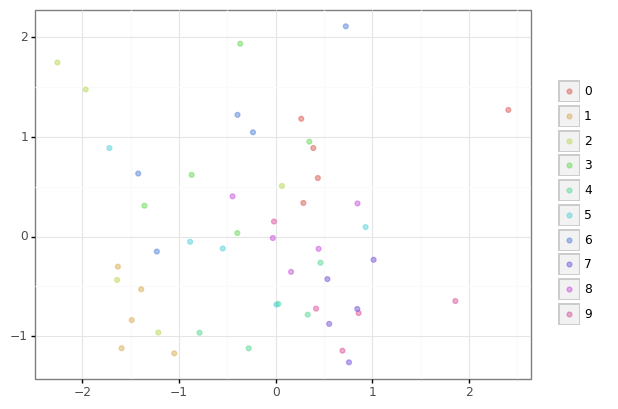

<ggplot: (143121783742)>

In [17]:
from plotnine import ggplot, aes, geom_line,geom_point,theme_bw,scale_color_hue,ggsave,geom_label

sample=coded_test[indices]
#sample=coded_test
n=50
nugde=np.max(np.abs(sample))*0.01/3

plot=ggplot() +\
geom_point(aes(x=sample[:,0], y=sample[:,1], color=np.round(sample[:,2]).astype('int32').astype('str')),alpha=0.5) +\
geom_label(aes(x=sample[:,0]+nugde, y=sample[:,1]+nugde, label=sample[:,2].astype('int32').astype('str')),alpha=0.5,size=4) +\
scale_color_hue(name=' ')+\
theme_bw()

ggsave(plot=plot, filename=Model_name+'.png', dpi=200)

ggplot() +\
geom_point(aes(x=sample[:,0], y=sample[:,1], color=np.round(sample[:,2]).astype('int32').astype('str')),alpha=0.5) +\
scale_color_hue(name=' ')+\
theme_bw()

In [ ]:
plt.figure(figsize=(6.4*5,6.4*2))

for i in range(10):
    ref=coded_test[teste_y==i]
    media=np.mean(ref,axis=0,keepdims=True)
    cov=np.cov(ref,rowvar=False)
    for j in range(3)
        noise=random.multivariate_normal(media, cov)
        sample=media+noise
        fig=plt.imshow(destransf(Decoder.predict(teste)).reshape([28,28]),cmap='Greys')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    
plt.savefig('Encoded_values_10.png')

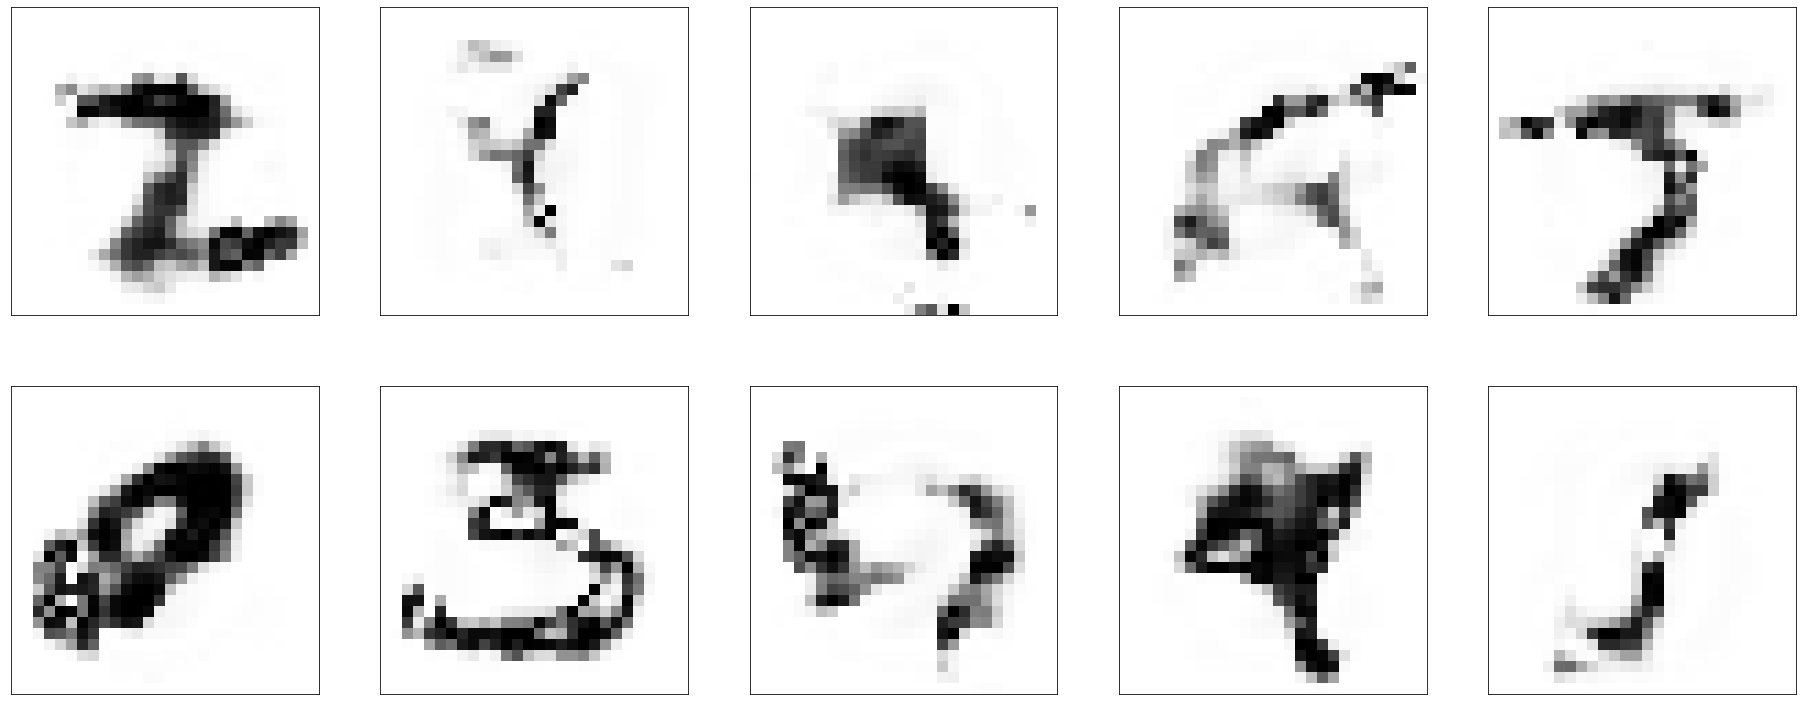

In [39]:
plt.figure(figsize=(6.4*5,6.4*2))

for i in range(10):
    
    teste=np.zeros([1,10],dtype=float_type)
    teste[0,i]=1
    plt.subplot(2, 5, i+1)
    fig=plt.imshow(destransf(Decoder.predict(teste)).reshape([28,28]),cmap='Greys')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    
plt.savefig('Encoded_values_10.png')

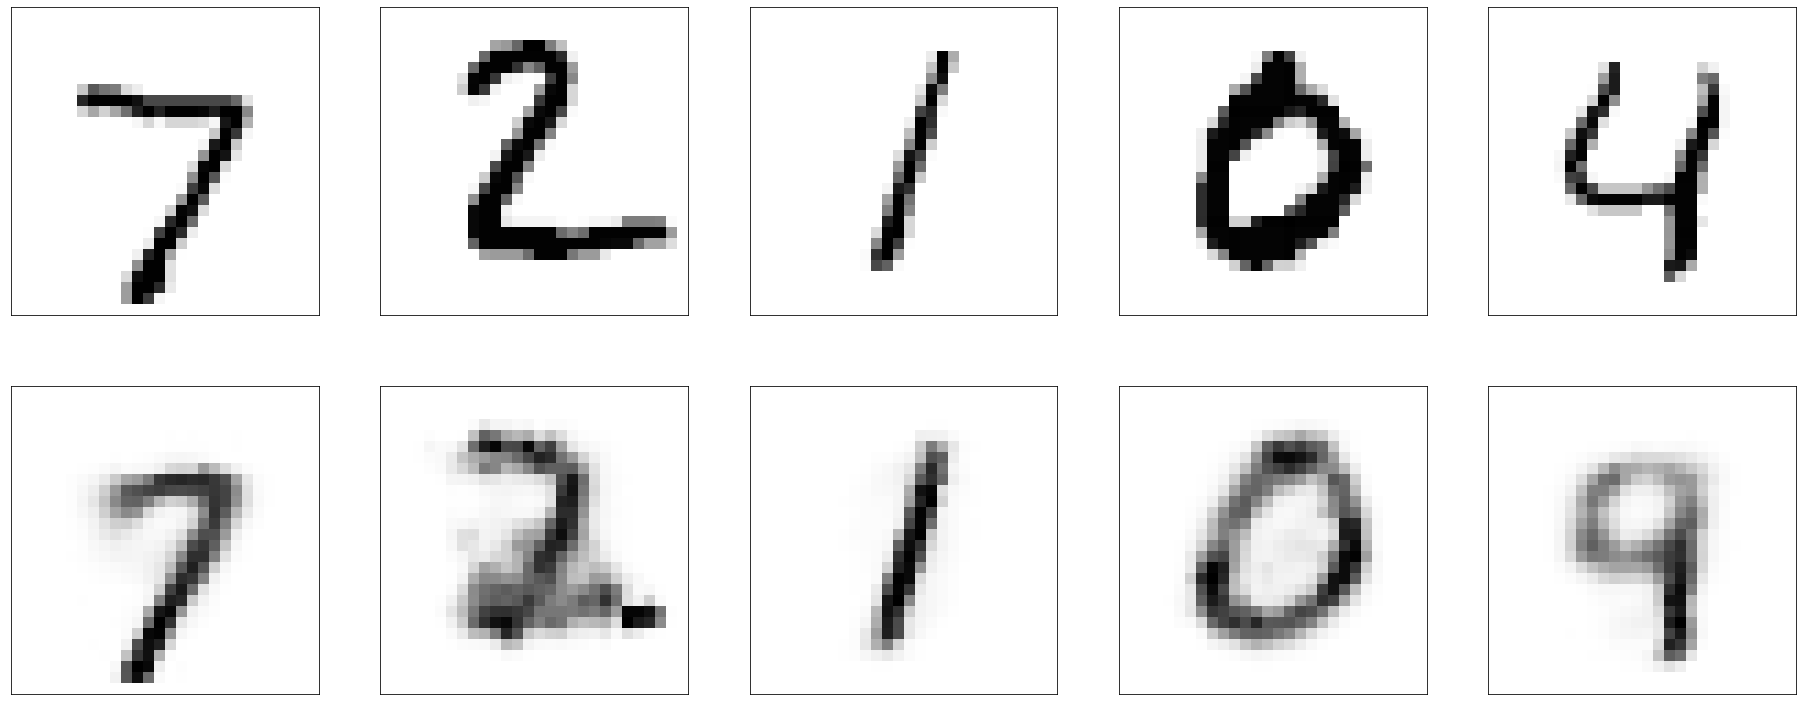

In [83]:
plt.figure(figsize=(6.4*5,6.4*2))

for i in range(5):
    plt.subplot(2, 5, i+1)
    fig=plt.imshow(destransf(test_x[i]).reshape([28,28]),cmap='Greys')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    
    plt.subplot(2, 5, i+6)
    fig=plt.imshow(destransf(Network.predict(test_x[i:i+1])).reshape([28,28]),cmap='Greys')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    
plt.savefig('Encoded_model1.png')

In [9]:
Encoder.predict(test_x)

array([[ 1.0773971 , -0.42692664],
       [ 0.90830123,  4.35052   ],
       [ 0.03334659, -0.1014303 ],
       ...,
       [ 0.41216826, -0.35248008],
       [-2.2212439 , -4.737972  ],
       [-1.7240053 ,  0.911348  ]], dtype=float32)

In [10]:
coded_test[:n,2]

array([7., 2., 1., 0., 4., 1., 4., 9., 5., 9., 0., 6., 9., 0., 1., 5., 9.,
       7., 3., 4., 9., 6., 6., 5., 4., 0., 7., 4., 0., 1., 3., 1., 3., 4.,
       7., 2., 7., 1., 2., 1., 1., 7., 4., 2., 3., 5., 1., 2., 4., 4.],
      dtype=float32)